# Jane Street Puzzle - January 2025 - Somewhat Square Sudoku

## Problem Statement

<div class="center"><img src="images/20250101_sudoku.png" style="background-color: white;" class="dark_img" alt=""></div>

Fill the empty cells in the grid above with digits such that each row, column, and outlined 3-by-3 box contains the same set of nine unique digits (1), and such that the nine 9-digit numbers (2) formed by the rows of the grid has the highest-possible GCD over any such grid.

Some of the cells have already been filled in. The answer to this puzzle is the 9-digit number formed by the middle row in the completed grid.

- (1) that is, you’ll be using nine of the ten digits (0-9) in completing this grid 

- (2) possibly with a leading 0

## Solution

First, we generate all the permutations of 9 digits. We will check every combination of 9 digits but for now let's focus on a single one. 

Then, we create 9 groups (one for each row) and add permutations to these groups. If a permutation can fit in a row (based on the sudoku rules and filled cells), it is added to the group corresponding to this row. 

Then, we initialise a hashmap where the key is some divisor and the values are another hashmap where the key is a row indice and the value is a list of permutation. For each permutation in a group (corresponding to a row), we compute all its divisors and fill the map. After this, each divisor of a permutation is associated with some rows and the corresponding permutations (those that can be put in the row and that is divisible by the divisor). For a divisor to be valid, it needs to have at least one valid permutation for each row. Therefore, we exclude the divisors for which this is not the case.

Now, we can sort the remaining divisors from largest to smallest and try to generate a grid until we find a valid one. This guarantees that we first find the grid with highest GCD among all the grids containing the current set of digits.

In order to generate the grids, we use backtracking coupled with a meet-in-the-middle approach. We generate first generate all the valid blocks for the first 4 rows. We try putting the permutations with the current divisors in the relevant rows. Whenever adding a row violates the sudoku conditions, we backtrack and continue. If we cannot find a block for the first 4 rows, we can directly go to the next divisor. We do the same thing for the block with the last 4 rows. The idea behind this is to avoid trying to fill the middle row until the end as this is the one with most potential values. Also, if it is not possible to have a valid block for the last rows, we do not try creating such a block for each valid block of the first 4 rows. This saves a lot of computations. Finally, we try combining a block with the first 4 rows and a block with the last 4 rows with a middle permutation. As soon as we find a valid grid, we can return it and keep the middle row as a candidate.

Finally, we can repeat this for each combination of 9 digits and keep only the solution with highest GCD. In practice, we only need to quickly try each digits combination to find that the highest GCD is achieved by removing the digit 4.

In [1]:
import itertools
import sympy
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
# Generate all permutations of 9 digits excluding a specific digit
perms = itertools.permutations([str(x) for x in range(10) if x != 4])

In [3]:
# Generate groups of permutations (permutations that can go in row 1, row 2, etc)

def generate_groups(perms):
    """ Function to associate permutations with potential rows """
    groups = [[] for _ in range(9)]
    for i, perm in enumerate(perms):
        if perm[7] == '2' and not '5' in [perm[6], perm[8]] and not '0' in [perm[2], perm[4]]:
            groups[0].append(i)
        if perm[8] == '5' and not '2' in [perm[1], perm[3], perm[5], perm[7]] and not '0' in [perm[2], perm[4]] and not '2' in [perm[0], perm[1], perm[2]]:
            groups[1].append(i)
        if perm[1] == '2' and not '5' in [perm[6], perm[8]] and not '0' in [perm[2], perm[4]] and not '5' in [perm[6], perm[7], perm[8]]:
            groups[2].append(i)
        if perm[2] == '0' and not '2' in [perm[1], perm[3], perm[5], perm[7]] and not '5' in [perm[6], perm[8]] and not '2' in [perm[3], perm[4], perm[5]]:
            groups[3].append(i)
        if not '2' in [perm[1], perm[3], perm[5], perm[7]] and not '5' in [perm[6], perm[8]] and not '0' in [perm[2], perm[4]] and not '0' in [perm[0], perm[1], perm[2]] and not '2' in [perm[3], perm[4], perm[5]]:
            groups[4].append(i)
        if perm[3] == '2' and not '5' in [perm[6], perm[8]] and not '0' in [perm[2], perm[4]] and not '0' in [perm[0], perm[1], perm[2]]:
            groups[5].append(i)
        if perm[4] == '0' and not '2' in [perm[1], perm[3], perm[5], perm[7]] and not '5' in [perm[6], perm[8]] and not '2' in [perm[3], perm[5]] and not '5' in [perm[6], perm[7], perm[8]]:
            groups[6].append(i)
        if perm[5] == '2' and not '5' in [perm[6], perm[8]] and not '0' in [perm[2], perm[4]] and not '0' in [perm[3], perm[4]] and not '5' in [perm[6], perm[7], perm[8]]:
            groups[7].append(i)
        if perm[6] == '5' and not '2' in [perm[1], perm[3], perm[5], perm[7]] and not '0' in [perm[2], perm[4]] and not '0' in [perm[3], perm[4], perm[5]] and not '2' in [perm[3], perm[4], perm[5]]:
            groups[8].append(i)
    return groups


perms = list(perms)
g = generate_groups(perms)

In [4]:
# Generate a mapping for each divisor of the permutations
# We keep divisors that have at list one permutation in each row

divisors = defaultdict(lambda: defaultdict(list))

# Create a mapping where for each divisor and each row, we have the valid permutations
for i in range(9):
    for x in g[i]:
        divs = sympy.divisors(int(''.join(perms[x])))
        for d in divs:
            divisors[d][i].append(x)

# If divisor cannot have a number in each row, remove the divisor
for d in divisors.copy():
    if len(divisors[d]) < 9:
        del divisors[d]

In [5]:
def generate_grid(d):
    """ Function to generate the grid using backtracking and meet in the middle approach"""

    # Generate potential top 4 rows
    block1 = []
    for row1 in divisors[d][0]:
        row1 = perms[row1]
        for row2 in divisors[d][1]:
            row2 = perms[row2]
            if not (len(set(row1[:3] + row2[:3])) == 6 and len(set(row1[3:6] + row2[3:6])) == 6 and len(set(row1[6:9] + row2[6:9])) == 6):
                continue
            for row3 in divisors[d][2]:
                row3 = perms[row3]
                if not (len(set(row1[:3] + row2[:3] + row3[:3])) == 9 and len(set(row1[3:6] + row2[3:6] + row3[3:6])) == 9 and len(set(row1[6:9] + row2[6:9] + row3[6:9])) == 9):
                    continue
                for row4 in divisors[d][3]:
                    row4 = perms[row4]
                    has_break = False
                    for i in range(9):
                        if not (len(set([row1[i], row2[i], row3[i], row4[i]])) == 4):
                            has_break = True
                            break
                    if not has_break:
                        block1.append([row1, row2, row3, row4])
    if len(block1) == 0:
        return

    # Generate potential bottom 4 rows
    block3 = []
    for row1 in divisors[d][6]:
        row1 = perms[row1]
        for row2 in divisors[d][7]:
            row2 = perms[row2]
            if not (len(set(row1[:3] + row2[:3])) == 6 and len(set(row1[3:6] + row2[3:6])) == 6 and len(set(row1[6:9] + row2[6:9])) == 6):
                continue
            for row3 in divisors[d][8]:
                row3 = perms[row3]
                if not (len(set(row1[:3] + row2[:3] + row3[:3])) == 9 and len(set(row1[3:6] + row2[3:6] + row3[3:6])) == 9 and len(set(row1[6:9] + row2[6:9] + row3[6:9])) == 9):
                    continue
                for row4 in divisors[d][5]:
                    row4 = perms[row4]
                    has_break = False
                    for i in range(9):
                        if not (len(set([row1[i], row2[i], row3[i], row4[i]])) == 4):
                            has_break = True
                            break
                    if not has_break:
                        block3.append([row4, row1, row2, row3])
    if len(block3) == 0:
        return

    # Generate full grid from top block, bottom block and middle row
    for b1 in block1:
        for b3 in block3:
            has_break = False
            for i in range(9):
                if not (len(set([b1[0][i], b1[1][i], b1[2][i], b1[3][i], b3[0][i], b3[1][i], b3[2][i], b3[3][i]])) == 8):
                    has_break = True
                    break
            if not has_break:
                for b2 in divisors[d][4]:
                    b2 = perms[b2]
                    for i in range(9):
                        if not (len(set([b1[0][i], b1[1][i], b1[2][i], b1[3][i], b3[0][i], b3[1][i], b3[2][i], b3[3][i], b2[i]])) == 9):
                            has_break = True
                            break
                    if not has_break:
                        if not (len(set(b1[3][:3] + b3[0][:3] + b2[:3])) == 9 and len(set(b1[3][3:6] + b3[0][3:6] + b2[3:6])) == 9 and len(set(b1[3][6:9] + b3[0][6:9] + b2[6:9])) == 9):
                            continue
                        return b1 + [b2] + b3

    return


In [6]:
# Starting from the largest divisors, try to generate a valid grid until one is found
for d in sorted(divisors, reverse=True):
    grid = generate_grid(d)
    if grid:
        print(f'Highest GCD is {d}. \n')
        print(f'Answer is {"".join(grid[4])}.')
        break

Highest GCD is 12345679. 

Answer is 283950617.


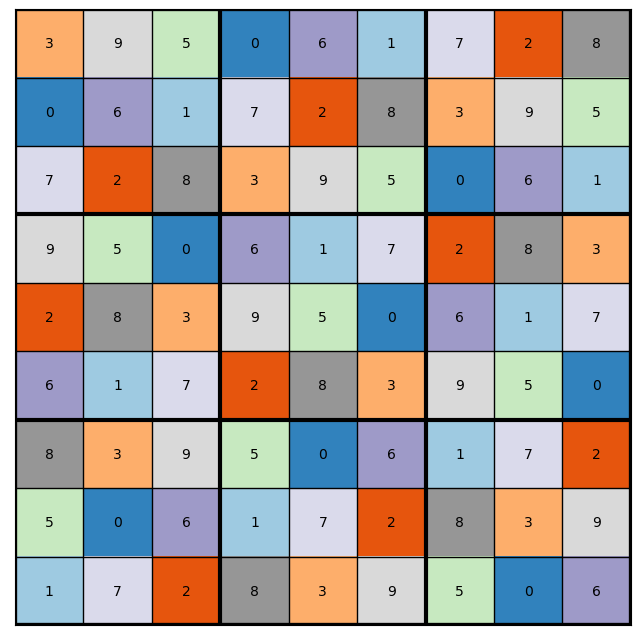

In [7]:
# Plot the resulting grid

fig, ax = plt.subplots(figsize=(8, 8))

# Convert grid values to integer
for i in range(len(grid)):
    grid[i] = list(grid[i])
    for j in range(len(grid[0])):
        grid[i][j] = int(grid[i][j])

# Display the grid with color mapping
cmap = cm.get_cmap('tab20c')  # Choose a colormap
im = ax.imshow(grid, cmap=cmap)

# Add text annotations with the values
for (i, j), val in np.ndenumerate(grid):
    ax.text(j, i, val, ha='center', va='center', color='k', fontsize=10)

# Add smaller grid lines
for i in range(10):  # Regular grid lines
    ax.hlines(i - 0.5, -0.5, 8.5, colors='k', linewidth=1)
    ax.vlines(i - 0.5, -0.5, 8.5, colors='k', linewidth=1)

# Add thicker lines for 3x3 subgrids
for i in range(0, 10, 3):  # Thicker lines every 3 cells
    ax.hlines(i - 0.5, -0.5, 8.5, colors='black', linewidth=3)
    ax.vlines(i - 0.5, -0.5, 8.5, colors='black', linewidth=3)

# Add border around the entire grid
ax.hlines(-0.5, -0.5, 8.5, colors='black', linewidth=3)
ax.hlines(8.5, -0.5, 8.5, colors='black', linewidth=3)
ax.vlines(-0.5, -0.5, 8.5, colors='black', linewidth=3)
ax.vlines(8.5, -0.5, 8.5, colors='black', linewidth=3)

# Remove major ticks
ax.set_xticks([])
ax.set_yticks([])

plt.show()
